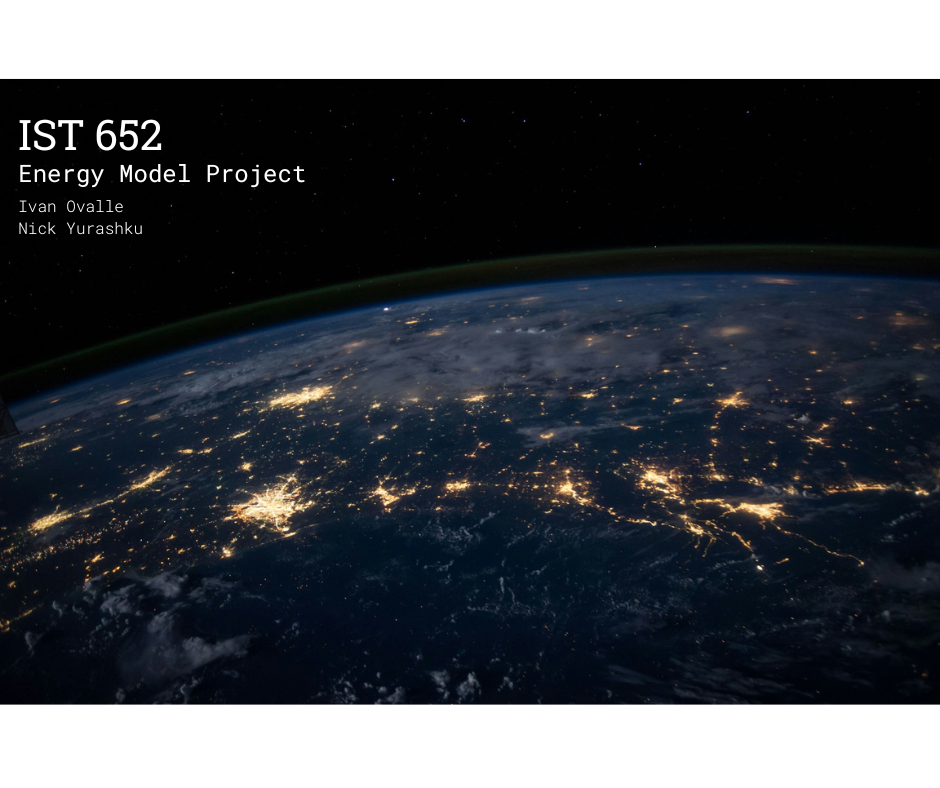

# Introduction:

Our project aims to develop an Energy Consumption Model that leverages a data pipeline for aggregating relevant weather and consumer energy data and applies predictive analytics to assess how energy is consumed in terms of sales.

# Project Overview:

The project will involve two main components: building a data pipeline and creating a predictive model for energy used in households. The pipeline will gather data from various sources such as weather forecasting data and US/EU household energy data. The predictive model will use machine learning techniques to analyze this data and generate insights into energy usage.

# Data Sources:

The data pipeline will integrate data from two data sources:

Weather forecasting and historical data: https://open-meteo.com/en/docs

US energy consumption by household: https://eia.gov

# Methodology:

Data Collection (Extraction) - Establish APIs and data retrieval methods to collect data from the identified sources.

Data Processing (Transform) - Clean and preprocess the data using Python libraries like Pandas.

Database (Loading) - Store data into a MongoDB database.

Model Development - Implement machine learning algorithms for energy consumption prediction, likely employing techniques such as regression and gradient boosting (XgBoost).

Validation - Test the model's accuracy and reliability against a subset of the data.

# Questions:

1. Can the sales of energy be predicted using a machine learning model? If so, what model works best? Starting with the most popular, Regression analysis, we will try to predict sales.
2. A popular machline learning algorithm used right now is the XGBoost model which stands for extreme gradient boosting. Although popular, it does tend to overfit data but will this still work for our needs?
3. Lastly, a random forest model will be attempted to be used to predict sales.

# Step 1: Data Collection

For this project, two API pipelines had to be built in order to grab weather data and energy price data. The data was then uploaded into MongoDB.

## First, the energy prices data

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from pymongo import MongoClient
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
import urllib.request
import json
import pymongo

In [2]:
def get_eia_data():
    offset = 0
    all_data = pd.DataFrame([])
    API_KEY = 'cfYdPQdEqMyWAHfPTVR3b8v02ZbD1GlOcaX37FWS'
    max_rows = 120000  # setting maximum because we checked the website and that is all the data that they have available. We dont want it to keep running nonstop.

    while True:
        url = f'https://api.eia.gov/v2/electricity/retail-sales/data/?api_key={API_KEY}&frequency=monthly&data[0]=customers&data[1]=price&data[2]=revenue&data[3]=sales&sort[0][column]=period&sort[0][direction]=desc&offset={offset}&length=5000'
        res = requests.get(url)
        
        # Check if the request was successful
        assert res.status_code == 200, f"Request failed with status code {res.status_code}"
        
        data = res.json()
        df = pd.DataFrame(data['response']['data'])
        
        if not df.empty:
            all_data = pd.concat([all_data, df], ignore_index=True)
            # Check if the maximum rows limit is reached or exceeded
            if len(all_data) >= max_rows:
                break
        else:
            # If no data is returned, stop the loop
            break
        
        offset += 5000
        # API limits things to just 5000 rows
        
    return all_data[:max_rows]

#function to get the data
all_data = get_eia_data()

In [3]:
all_data

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units
0,2023-12,HI,Hawaii,TRA,transportation,0,0,0,0,number of customers,cents per kilowatthour,million dollars,million kilowatthours
1,2023-12,HI,Hawaii,RES,residential,446136,41.6,100.00765,240.42277,number of customers,cents per kilowatthour,million dollars,million kilowatthours
2,2023-12,HI,Hawaii,OTH,other,None,None,None,None,number of customers,cents per kilowatthour,million dollars,million kilowatthours
3,2023-12,HI,Hawaii,IND,industrial,814,35.4,100.66087,284.35347,number of customers,cents per kilowatthour,million dollars,million kilowatthours
4,2023-12,HI,Hawaii,COM,commercial,59899,39.33,87.95229,223.64862,number of customers,cents per kilowatthour,million dollars,million kilowatthours
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102667,2001-01,MTN,Mountain,COM,commercial,None,5.9,344.904,5846.07903,number of customers,cents per kilowatthour,million dollars,million kilowatthours
102668,2001-01,MTN,Mountain,IND,industrial,None,4.18,229.41675,5490.18787,number of customers,cents per kilowatthour,million dollars,million kilowatthours
102669,2001-01,MTN,Mountain,OTH,other,None,5.31,30.24798,569.87616,number of customers,cents per kilowatthour,million dollars,million kilowatthours
102670,2001-01,MTN,Mountain,RES,residential,None,6.7,458.81151,6846.01229,number of customers,cents per kilowatthour,million dollars,million kilowatthours


After the API pull is complete, the data is inserted into the database.

In [ ]:
# Convert DataFrame to dictionary
data_dict = all_data.to_dict("records")

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["ist652"]  
collection = db["eia_data"]  

# Insert into MongoDB
collection.insert_many(data_dict)

# Close the connection
client.close()


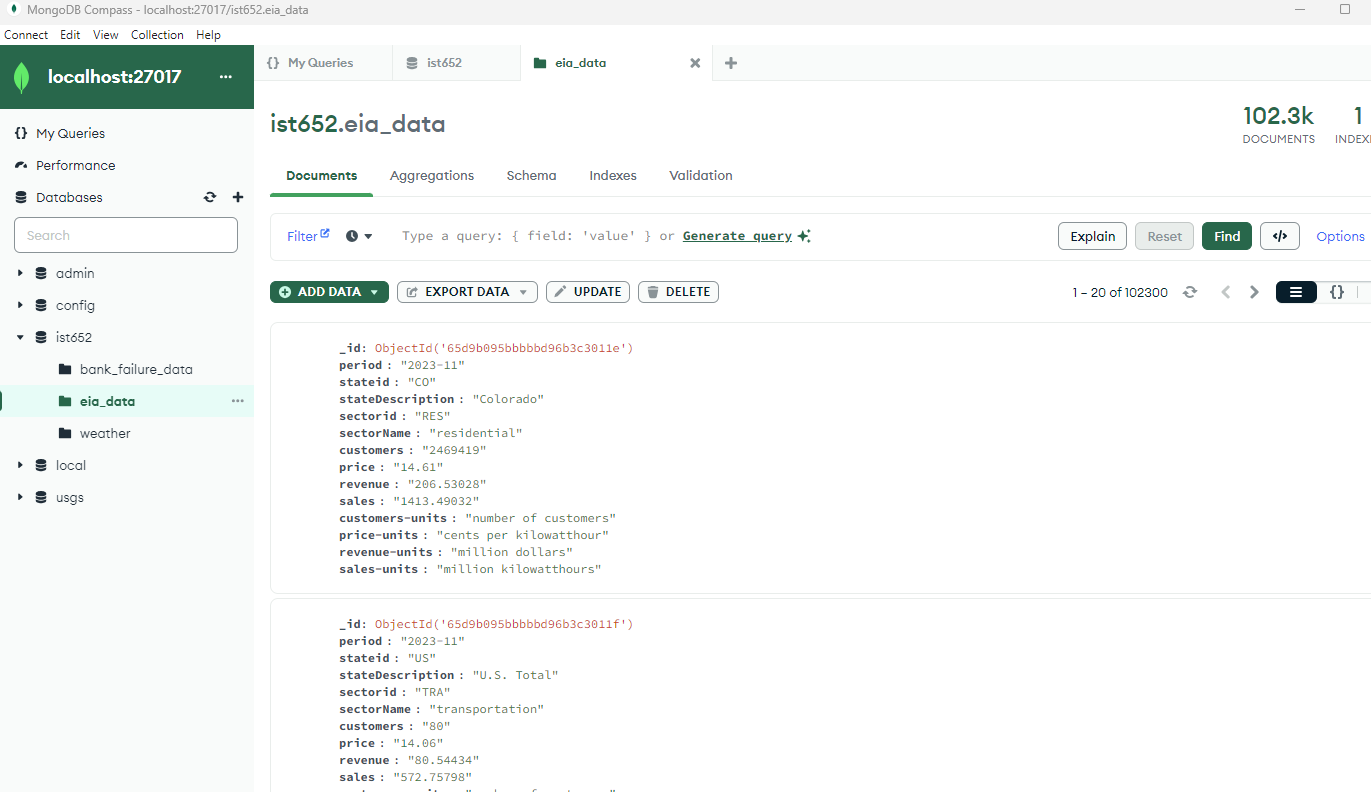

## Second, the weather data:

Creating an API pipeline settings

In [26]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
"latitude": [40.7143, 25.47, 32.7831, 41.85, 37.7749,29.75,34.052235,28.5383,27.964157,33.753746,32.776566,
            35.227085,38.89511,39.299236,39.952583,42.361145,38.627003,30.266666,39.742043,36.114704,
            33.448376,47.608013,44.986656,45.523064,32.715738],
"longitude": [-74.006, -80.13, -96.8067, -87.65, -122.4194,-95.358,-118.243683,-81.379234,-82.452606,
              -84.386330,-79.930923,-80.843124,-77.03637,-76.609383,-75.165222,-71.057083,-90.199402,
             -97.733330,-104.991531,-115.201462,-112.074036,-122.335167,-93.258133,-122.676483,-117.161084],
"start_date": "2001-01-01",
"end_date": "2023-11-30",
"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "sunshine_duration", "precipitation_sum"],
"temperature_unit": "fahrenheit",
"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

Function that obtains daily weather data

In [27]:
def get_weather_data(response):
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
    daily_sunshine_duration = daily.Variables(3).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s"),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["sunshine_duration"] = daily_sunshine_duration
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_df = pd.DataFrame(data = daily_data)
    return daily_df
    

Generate the daily weather data from each location using a for loop and concatenating into a dataframe

In [28]:
df = pd.DataFrame() 
for i in responses:
    df = pd.concat([df, get_weather_data(i)],ignore_index=True)
    
df

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,sunshine_duration,precipitation_sum
0,2001-01-01,26.660301,12.080301,18.507801,29144.779297,0.000000
1,2001-01-02,22.700300,6.320301,14.469050,29261.923828,0.000000
2,2001-01-03,23.060301,3.620300,11.844050,29280.345703,0.000000
3,2001-01-04,29.270300,6.230301,14.052802,25315.408203,0.000000
4,2001-01-05,30.710300,7.850300,18.894049,5519.396484,0.141732
...,...,...,...,...,...,...
209220,2023-11-26,68.136795,45.276802,55.743046,32909.789062,0.000000
209221,2023-11-27,69.216797,45.906799,56.489300,32406.455078,0.000000
209222,2023-11-28,67.956802,47.256798,58.236797,32400.000000,0.000000
209223,2023-11-29,64.536797,48.606800,56.343052,30027.144531,0.027559


In [29]:
df.columns = ['date', 'max_temp', 'min_temp',
       'temp_mean', 'sunshine_duration', 'precipitation']

Appending the cities to the dataframe based on the coordinates from the weather response

In [30]:
cities = ['New York,NY', 'Miami,FL', 'Dallas,TX','Chicago,IL', 'San Francisco,CA','Houston,TX',
         'Los Angeles, CA','Orlando,FL','Tampa,FL', 'Atlanta,GA', 'Charleston,SC','Charlotte,NC',
         'Washington,DC','Baltimore, MD','Philadelphia,PA','Boston,MA','Saint Louis,MO','Austin,TX',
         'Denver,CO','Las Vegas,NV','Phoenix,AZ','Seattle,WA','Minneapolis,MN','Portland,OR','San Diego,CA']

values = []
start = 0
stop = 8369  #weather cycle value for each city 
#Obtain city values based on each daily weather iteration
for city in cities:
    for i in range(start,stop):
        values.append(city)
    start = start + 8369
    stop = stop + 8369
#Assign value to a new dataframe column

df['location'] = values

#Confirming the length of each city data is the same
for i in set(values):
    print("length of values",i,values.count(i))

length of values Baltimore, MD 8369
length of values Los Angeles, CA 8369
length of values Denver,CO 8369
length of values San Francisco,CA 8369
length of values Phoenix,AZ 8369
length of values Dallas,TX 8369
length of values Philadelphia,PA 8369
length of values Boston,MA 8369
length of values Miami,FL 8369
length of values Houston,TX 8369
length of values Chicago,IL 8369
length of values Saint Louis,MO 8369
length of values San Diego,CA 8369
length of values Minneapolis,MN 8369
length of values New York,NY 8369
length of values Atlanta,GA 8369
length of values Orlando,FL 8369
length of values Charlotte,NC 8369
length of values Seattle,WA 8369
length of values Las Vegas,NV 8369
length of values Portland,OR 8369
length of values Austin,TX 8369
length of values Tampa,FL 8369
length of values Washington,DC 8369
length of values Charleston,SC 8369


Appending the coordinates from params and assigning to each city

In [31]:
coordinates = list(zip(params['longitude'],params['latitude']))  #Zip longitude and latitude 
start = 0
stop = 8369
iterator = 0
lons = []
lats = []
for city in cities:
    for i in range(start,stop):
        lons.append(coordinates[iterator][0])  #Add longitudes for each city
        lats.append(coordinates[iterator][1]) #Add latitudes
    iterator += 1
df['lon'] = lons
df['lat'] = lats

df
    


,date,max_temp,min_temp,temp_mean,sunshine_duration,precipitation,location,lon,lat
0,2001-01-01,26.660301,12.080301,18.507801,29144.779297,0.000000,"New York,NY",-74.006000,40.714300
1,2001-01-02,22.700300,6.320301,14.469050,29261.923828,0.000000,"New York,NY",-74.006000,40.714300
2,2001-01-03,23.060301,3.620300,11.844050,29280.345703,0.000000,"New York,NY",-74.006000,40.714300
3,2001-01-04,29.270300,6.230301,14.052802,25315.408203,0.000000,"New York,NY",-74.006000,40.714300
4,2001-01-05,30.710300,7.850300,18.894049,5519.396484,0.141732,"New York,NY",-74.006000,40.714300
...,...,...,...,...,...,...,...,...,...
209220,2023-11-26,68.136795,45.276802,55.743046,32909.789062,0.000000,"San Diego,CA",-117.161084,32.715738
209221,2023-11-27,69.216797,45.906799,56.489300,32406.455078,0.000000,"San Diego,CA",-117.161084,32.715738
209222,2023-11-28,67.956802,47.256798,58.236797,32400.000000,0.000000,"San Diego,CA",-117.161084,32.715738
209223,2023-11-29,64.536797,48.606800,56.343052,30027.144531,0.027559,"San Diego,CA",-117.161084,32.715738


Apply Lambda function to obtain a state column from each city based on state ID

In [32]:
df['stateid'] = df['location'].apply(lambda x: x[-2]+x[-1])

In [33]:
df.iloc[:,1:5] = round(df.iloc[:,1:5]) #Format float values
df

,date,max_temp,min_temp,temp_mean,sunshine_duration,precipitation,location,lon,lat,stateid
0,2001-01-01,27.0,12.0,19.0,29145.0,0.000000,"New York,NY",-74.006000,40.714300,NY
1,2001-01-02,23.0,6.0,14.0,29262.0,0.000000,"New York,NY",-74.006000,40.714300,NY
2,2001-01-03,23.0,4.0,12.0,29280.0,0.000000,"New York,NY",-74.006000,40.714300,NY
3,2001-01-04,29.0,6.0,14.0,25315.0,0.000000,"New York,NY",-74.006000,40.714300,NY
4,2001-01-05,31.0,8.0,19.0,5519.0,0.141732,"New York,NY",-74.006000,40.714300,NY
...,...,...,...,...,...,...,...,...,...,...
209220,2023-11-26,68.0,45.0,56.0,32910.0,0.000000,"San Diego,CA",-117.161084,32.715738,CA
209221,2023-11-27,69.0,46.0,56.0,32406.0,0.000000,"San Diego,CA",-117.161084,32.715738,CA
209222,2023-11-28,68.0,47.0,58.0,32400.0,0.000000,"San Diego,CA",-117.161084,32.715738,CA
209223,2023-11-29,65.0,49.0,56.0,30027.0,0.027559,"San Diego,CA",-117.161084,32.715738,CA


Converting daily weather data into string format

In [34]:
df.reset_index(inplace=True)
data_dict = df.to_dict("records")
data_dict

[{'index': 0,
  'date': Timestamp('2001-01-01 00:00:00'),
  'max_temp': 27.0,
  'min_temp': 12.0,
  'temp_mean': 19.0,
  'sunshine_duration': 29145.0,
  'precipitation': 0.0,
  'location': 'New York,NY',
  'lon': -74.006,
  'lat': 40.7143,
  'stateid': 'NY'},
 {'index': 1,
  'date': Timestamp('2001-01-02 00:00:00'),
  'max_temp': 23.0,
  'min_temp': 6.0,
  'temp_mean': 14.0,
  'sunshine_duration': 29262.0,
  'precipitation': 0.0,
  'location': 'New York,NY',
  'lon': -74.006,
  'lat': 40.7143,
  'stateid': 'NY'},
 {'index': 2,
  'date': Timestamp('2001-01-03 00:00:00'),
  'max_temp': 23.0,
  'min_temp': 4.0,
  'temp_mean': 12.0,
  'sunshine_duration': 29280.0,
  'precipitation': 0.0,
  'location': 'New York,NY',
  'lon': -74.006,
  'lat': 40.7143,
  'stateid': 'NY'},
 {'index': 3,
  'date': Timestamp('2001-01-04 00:00:00'),
  'max_temp': 29.0,
  'min_temp': 6.0,
  'temp_mean': 14.0,
  'sunshine_duration': 25315.0,
  'precipitation': 0.0,
  'location': 'New York,NY',
  'lon': -74.006,
 

Importing Data into MongoDB

In [35]:
#establishing connection
client = MongoClient("mongodb://localhost:27017/")  
db = client["ist652"]  
collection = db["weather_data"] 

In [36]:
db.weather.insert_many(data_dict)
client.close()

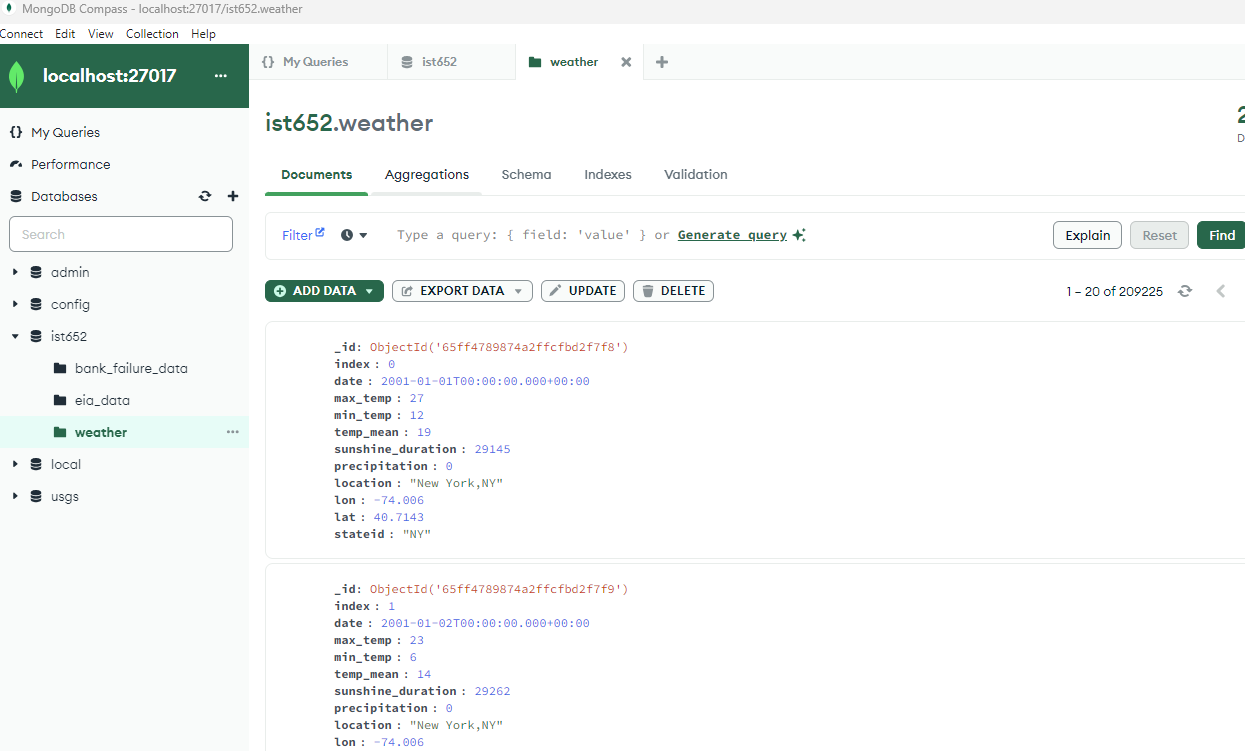

# Step 2: Extracting from MongoDB and Conducting Exploratory Data Analysis

## Energy Prices EDA

For this next stage, we wanted to pull the data from MongoDB and visualize the data to understand what we are working with.

In [10]:
# loading data from mongodb
client = MongoClient("mongodb://localhost:27017/")  
db = client["ist652"]  
collection = db["eia_data"]

data_cursor = collection.find({})

data_df = pd.DataFrame(list(data_cursor))


if '_id' in data_df.columns:
    data_df.drop(columns=['_id'], inplace=True)


client.close()


print(data_df.head())  

    period stateid stateDescription sectorid      sectorName  customers  \
0  2023-11      CO         Colorado      RES     residential    2469419   
1  2023-11      US       U.S. Total      TRA  transportation         80   
2  2023-11      US       U.S. Total      RES     residential  141052683   
3  2023-11      US       U.S. Total      OTH           other       None   
4  2023-11      US       U.S. Total      IND      industrial    1067082   

   price      revenue         sales      customers-units  \
0  14.61    206.53028    1413.49032  number of customers   
1  14.06     80.54434     572.75798  number of customers   
2  16.19  16616.69643  102609.84787  number of customers   
3   None         None          None  number of customers   
4    7.9   6420.28335   81292.11309  number of customers   

              price-units    revenue-units            sales-units  
0  cents per kilowatthour  million dollars  million kilowatthours  
1  cents per kilowatthour  million dollars  million 

In [11]:
df = pd.DataFrame(data_df)

The last four columns: 'customers-units', 'price-units', 'revenue-units', 'sales-units', is informative but would not be needed for further analysis. When speaking of prices, we will remember to refer to them as 'cents per kilowatthour' and etc. Down below, removing the extra columns.

In [12]:
df = df[['period','stateid','stateDescription','sectorid','sectorName','customers','price','revenue','sales']]

Down below, looking at descriptive statistics, it can be seen that the columns are missing appropriate data types which will need to be assigned.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102300 entries, 0 to 102299
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   period            102300 non-null  object
 1   stateid           102300 non-null  object
 2   stateDescription  102300 non-null  object
 3   sectorid          102300 non-null  object
 4   sectorName        102300 non-null  object
 5   customers         59187 non-null   object
 6   price             85229 non-null   object
 7   revenue           85229 non-null   object
 8   sales             85229 non-null   object
dtypes: object(9)
memory usage: 7.0+ MB


In [14]:
#turning column into date time
df['period'] = pd.to_datetime(df['period'])

In [15]:
#turning columns into string data types
df[['stateid','stateDescription','sectorid','sectorName']] = df[['stateid','stateDescription','sectorid','sectorName']].astype(str)

In [17]:
# turning these columns into numeric types
df['customers'] = pd.to_numeric(df['customers'])
df['price'] = pd.to_numeric(df['price'])
df['revenue'] = pd.to_numeric(df['revenue'])
df['sales'] = pd.to_numeric(df['sales'])

It can be see that sectorid is a categorical variable. Down below, it can be observed with value counts how many categorical variables we have - which may be needed to be transformed via hot encoding.

After that, the variable stateDescription can be observed so that there is awareness of where most of the information is coming from.

In [18]:
df['sectorid'].value_counts()

sectorid
OTH    17075
IND    17055
COM    17051
ALL    17048
RES    17039
TRA    17032
Name: count, dtype: int64

In [19]:
df['stateDescription'].value_counts()

stateDescription
New Jersey            1676
Massachusetts         1676
Michigan              1674
Nevada                1673
Colorado              1672
                      ... 
West South Central    1626
Virginia              1625
Texas                 1623
Utah                  1619
Vermont               1615
Name: count, Length: 62, dtype: int64

Down below are also the histograms of each numerical variable (datetime can be ignored) which show really heavy heavy-tailed distrubtions - we are speculating that the cause of this is due to regulations around price as well as the inelastic demand that can come from energy needs.

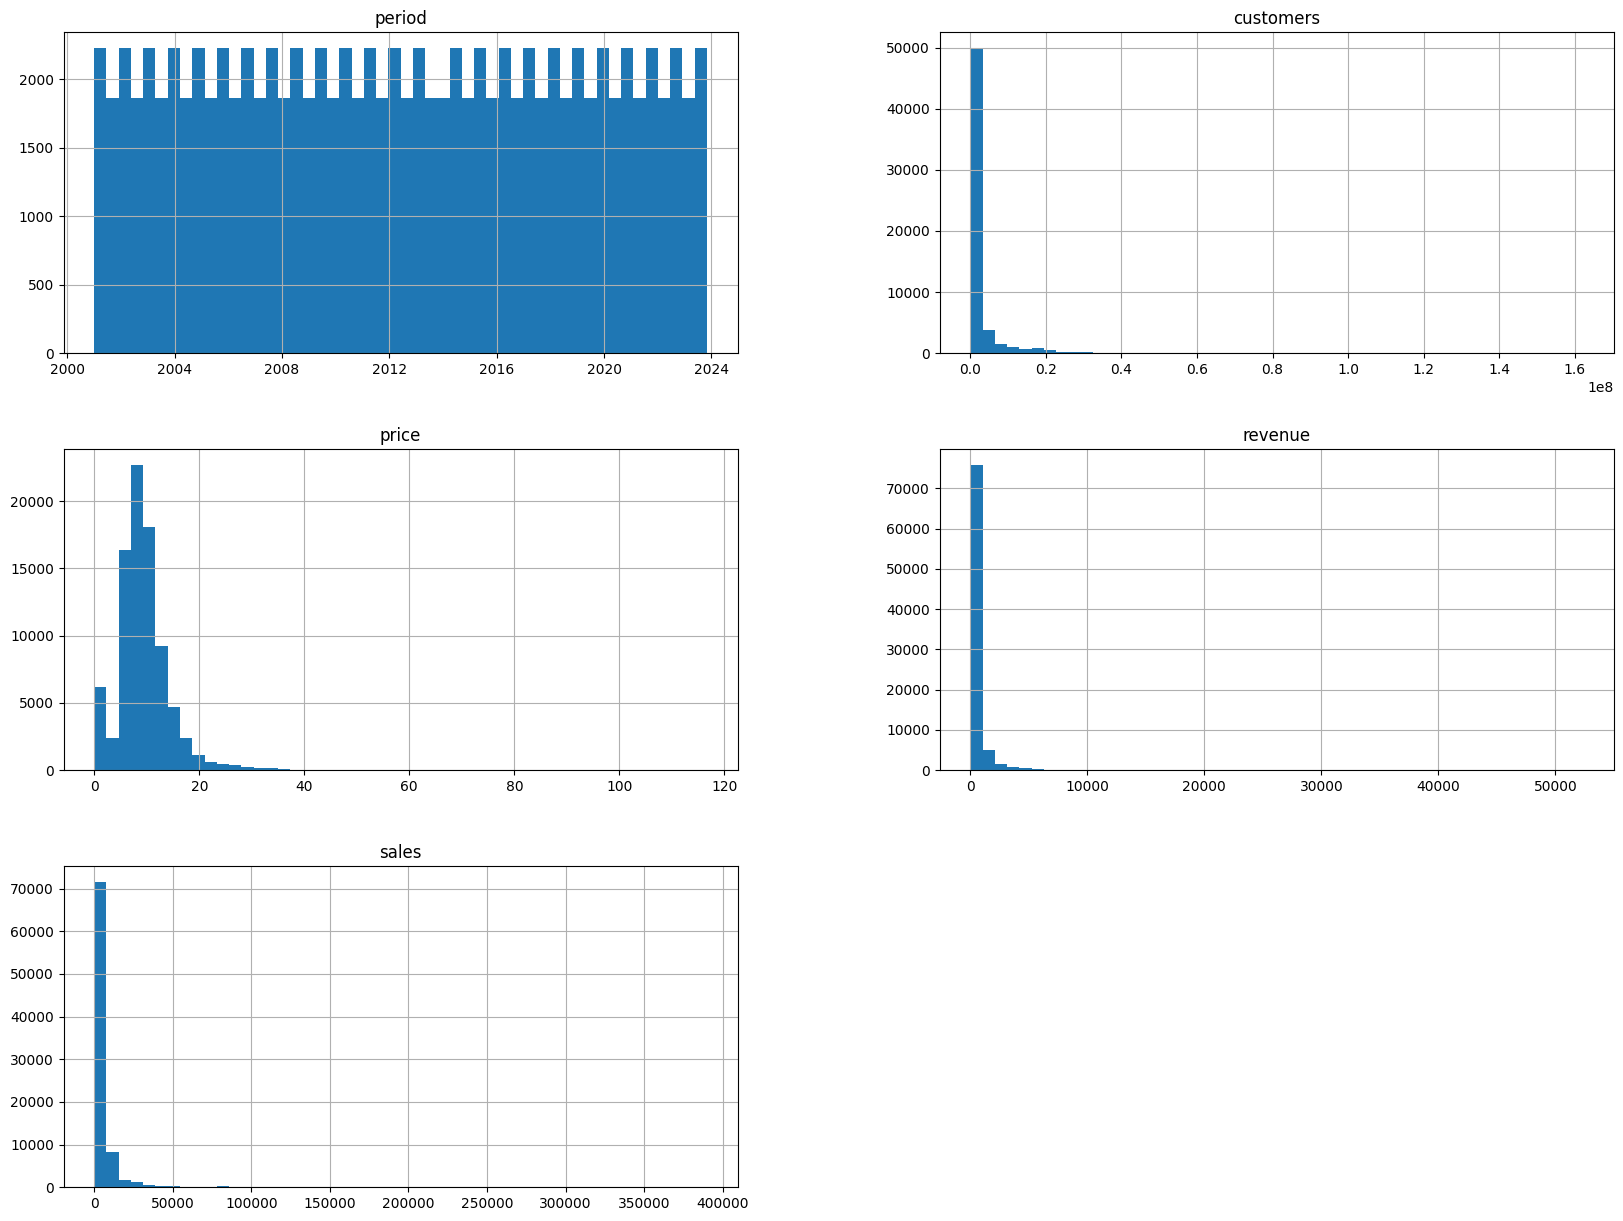

In [20]:
%matplotlib inline
df.hist(bins=50,figsize=(20,15))
plt.show()

## Weather Data EDA

In [57]:
# loading data from mongodb
client = MongoClient("mongodb://localhost:27017/")  
db = client["ist652"]  
collection = db["weather"]

data_cursor = collection.find({})

data_df = pd.DataFrame(list(data_cursor))


if '_id' in data_df.columns:
    data_df.drop(columns=['_id'], inplace=True)


client.close()


data_df

,index,date,max_temp,min_temp,temp_mean,sunshine_duration,precipitation,location,lon,lat,stateid
0,0,2001-01-01,27.0,12.0,19.0,29145.0,0.000000,"New York,NY",-74.006000,40.714300,NY
1,1,2001-01-02,23.0,6.0,14.0,29262.0,0.000000,"New York,NY",-74.006000,40.714300,NY
2,2,2001-01-03,23.0,4.0,12.0,29280.0,0.000000,"New York,NY",-74.006000,40.714300,NY
3,3,2001-01-04,29.0,6.0,14.0,25315.0,0.000000,"New York,NY",-74.006000,40.714300,NY
4,4,2001-01-05,31.0,8.0,19.0,5519.0,0.141732,"New York,NY",-74.006000,40.714300,NY
...,...,...,...,...,...,...,...,...,...,...,...
209220,209220,2023-11-26,68.0,45.0,56.0,32910.0,0.000000,"San Diego,CA",-117.161084,32.715738,CA
209221,209221,2023-11-27,69.0,46.0,56.0,32406.0,0.000000,"San Diego,CA",-117.161084,32.715738,CA
209222,209222,2023-11-28,68.0,47.0,58.0,32400.0,0.000000,"San Diego,CA",-117.161084,32.715738,CA
209223,209223,2023-11-29,65.0,49.0,56.0,30027.0,0.027559,"San Diego,CA",-117.161084,32.715738,CA


In [58]:
data_df.drop(columns=['index','stateid'],inplace=True)

In [59]:
#Checking for NAs among all columns
print(data_df.isna().sum())
#Information about the columns and their data type
print(data_df.info())
print(data_df.shape)

date                 0
max_temp             0
min_temp             0
temp_mean            0
sunshine_duration    0
precipitation        0
location             0
lon                  0
lat                  0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209225 entries, 0 to 209224
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               209225 non-null  datetime64[ns]
 1   max_temp           209225 non-null  float64       
 2   min_temp           209225 non-null  float64       
 3   temp_mean          209225 non-null  float64       
 4   sunshine_duration  209225 non-null  float64       
 5   precipitation      209225 non-null  float64       
 6   location           209225 non-null  object        
 7   lon                209225 non-null  float64       
 8   lat                209225 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memor

In [60]:
grouped = round(data_df.groupby(['location', 'lon','lat'], as_index=False).mean(),2)
grouped

,location,lon,lat,date,max_temp,min_temp,temp_mean,sunshine_duration,precipitation
0,"Atlanta,GA",-84.39,33.75,2012-06-16,71.10,53.51,61.53,31688.67,0.14
1,"Austin,TX",-97.73,30.27,2012-06-16,79.62,61.06,69.24,32284.76,0.10
2,"Baltimore, MD",-76.61,39.30,2012-06-16,64.79,48.75,56.06,30834.39,0.14
3,"Boston,MA",-71.06,42.36,2012-06-16,59.48,43.83,50.82,29407.60,0.13
4,"Charleston,SC",-79.93,32.78,2012-06-16,73.54,61.33,66.84,33671.25,0.13
5,"Charlotte,NC",-80.84,35.23,2012-06-16,71.01,52.54,60.96,31942.50,0.12
6,"Chicago,IL",-87.65,41.85,2012-06-16,57.78,45.50,50.84,30339.27,0.11
7,"Dallas,TX",-96.81,32.78,2012-06-16,77.00,59.19,67.13,32545.39,0.12
8,"Denver,CO",-104.99,39.74,2012-06-16,64.20,36.33,48.64,36341.77,0.05
9,"Houston,TX",-95.36,29.75,2012-06-16,78.53,62.34,69.48,32186.95,0.15


In [63]:
import plotly.express as px

def geo_map_display(df,title = None, zoom = 3.5, color = None, size = None):
    fig = px.scatter_mapbox(df,
                       lon = df['lon'], lat = df['lat'],
                       zoom = zoom,
                       color = df[color],
                       width = 1200, height = 650,
                       title = title,
                       size = df[size],
                       hover_name = df['location'],
                       text = df['location'])
    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(margin={'r':0,'t':50,'l':0, 'b':10})
    fig.show()

In [71]:
print(geo_map_display(grouped, title = 'Mean temperatures among major US cities', color = 'temp_mean', size = 'temp_mean'))


None


These results are expected since cities like Miami and Phoenix tend to stay the warmest throughout the year while cities <br>
like Minneapolis and Denver tend to stay colder on average.

In [70]:
print(geo_map_display(grouped, title = 'Average sunshine duration among major US cities', color = 'sunshine_duration', 
                      size = 'temp_mean'))

None


In this map, it lays out perfectly which cities see the most or least amount of sunshine, Cities in the desert like <br>
Las Vegas and Phoenix will see abundant sunshine while cities like Seattle would and most northern cities would see <br>
the least amount of sunshine.

In [69]:
print(geo_map_display(grouped, title = 'Average precipitation among major US cities', color = 'precipitation', 
                      size = 'temp_mean'))

None


Since precipitation is heavily correlated with amounts of sunshine, in this case a negative correlation. This would <br>
render the opposite results from the sunshine hours total. One big notable exception is Houston, while not being among <br>
the bottom in sunshine hours, it leads all other cities in total precipitation. 

### Weather observations on a month to month basis on average

Create function to format dates 

In [81]:
client = MongoClient("mongodb://localhost:27017/")  
db = client["ist652"]  
collection = db["weather"]

data_cursor = collection.find({})

data_df = pd.DataFrame(list(data_cursor))


if '_id' in data_df.columns:
    data_df.drop(columns=['_id','location'], inplace=True)


client.close()


data_df

,index,date,max_temp,min_temp,temp_mean,sunshine_duration,precipitation,lon,lat,stateid
0,0,2001-01-01,27.0,12.0,19.0,29145.0,0.000000,-74.006000,40.714300,NY
1,1,2001-01-02,23.0,6.0,14.0,29262.0,0.000000,-74.006000,40.714300,NY
2,2,2001-01-03,23.0,4.0,12.0,29280.0,0.000000,-74.006000,40.714300,NY
3,3,2001-01-04,29.0,6.0,14.0,25315.0,0.000000,-74.006000,40.714300,NY
4,4,2001-01-05,31.0,8.0,19.0,5519.0,0.141732,-74.006000,40.714300,NY
...,...,...,...,...,...,...,...,...,...,...
209220,209220,2023-11-26,68.0,45.0,56.0,32910.0,0.000000,-117.161084,32.715738,CA
209221,209221,2023-11-27,69.0,46.0,56.0,32406.0,0.000000,-117.161084,32.715738,CA
209222,209222,2023-11-28,68.0,47.0,58.0,32400.0,0.000000,-117.161084,32.715738,CA
209223,209223,2023-11-29,65.0,49.0,56.0,30027.0,0.027559,-117.161084,32.715738,CA


In [78]:
def format_dates(df, grouper = None):

    df['date'] = df.date.apply(lambda x: x.strftime('%Y-%m'))
    df = df.groupby([grouper,'date'], as_index=False).mean()
    df.iloc[:,2:5] = round(df.iloc[:,2:5]) #Formating float values except precipitation
    df['month'] = df.date.apply(lambda x: x[5:])
    df['month'] = pd.to_datetime(df['month'], format='%m').dt.strftime('%b')
    df['year'] = df['date'].apply(lambda x: x[0:4])
    return df

In [82]:
states_Monthly = format_dates(data_df, grouper = 'stateid') #Grouped by state
states_Monthly

,stateid,date,index,max_temp,min_temp,temp_mean,sunshine_duration,precipitation,lon,lat,month,year
0,AZ,2001-01,167395.0,63.0,39.0,49.774194,31039.387097,0.059944,-112.074036,33.448376,Jan,2001
1,AZ,2001-02,167424.0,67.0,41.0,53.285714,33629.750000,0.040917,-112.074036,33.448376,Feb,2001
2,AZ,2001-03,167454.0,77.0,48.0,62.870968,37603.096774,0.040132,-112.074036,33.448376,Mar,2001
3,AZ,2001-04,167484.0,85.0,55.0,69.733333,40286.333333,0.029790,-112.074036,33.448376,Apr,2001
4,AZ,2001-05,167515.0,101.0,70.0,86.645161,45935.193548,0.000254,-112.074036,33.448376,May,2001
...,...,...,...,...,...,...,...,...,...,...,...,...
5220,WA,2023-07,183980.0,78.0,57.0,66.354839,47452.032258,0.006350,-122.335167,47.608013,Jul,2023
5221,WA,2023-08,184011.0,78.0,60.0,67.709677,40689.580645,0.037592,-122.335167,47.608013,Aug,2023
5222,WA,2023-09,184042.0,69.0,54.0,59.700000,29525.600000,0.103150,-122.335167,47.608013,Sep,2023
5223,WA,2023-10,184072.0,60.0,47.0,52.419355,22614.290323,0.108712,-122.335167,47.608013,Oct,2023


In [83]:
def average_temps(df,*args, title = None):
    cal = round(df.groupby([*args], sort=False)['temp_mean'].mean())
    print(title)
    print(cal)

def average_sunshine(df,*args, title = None):
    cal = round(df.groupby([*args], sort=False)['sunshine_duration'].mean())
    print(title)
    print(cal)


In [84]:
print(average_temps(states_Monthly,states_Monthly.stateid, states_Monthly.month, 
                    title = 'Average temperatures by month'))

print(average_temps(states_Monthly,states_Monthly.stateid, states_Monthly.month, 
                    title = 'Average temperatures by month'))

Average temperatures by month
stateid  month
AZ       Jan      53.0
         Feb      57.0
         Mar      65.0
         Apr      73.0
         May      82.0
                  ... 
WA       Aug      66.0
         Sep      60.0
         Oct      52.0
         Nov      44.0
         Dec      39.0
Name: temp_mean, Length: 228, dtype: float64
None
Average temperatures by month
stateid  month
AZ       Jan      53.0
         Feb      57.0
         Mar      65.0
         Apr      73.0
         May      82.0
                  ... 
WA       Aug      66.0
         Sep      60.0
         Oct      52.0
         Nov      44.0
         Dec      39.0
Name: temp_mean, Length: 228, dtype: float64
None


### Plotting temperature data for each state

As one would predict, weather data is predictable as it is cyclical. 

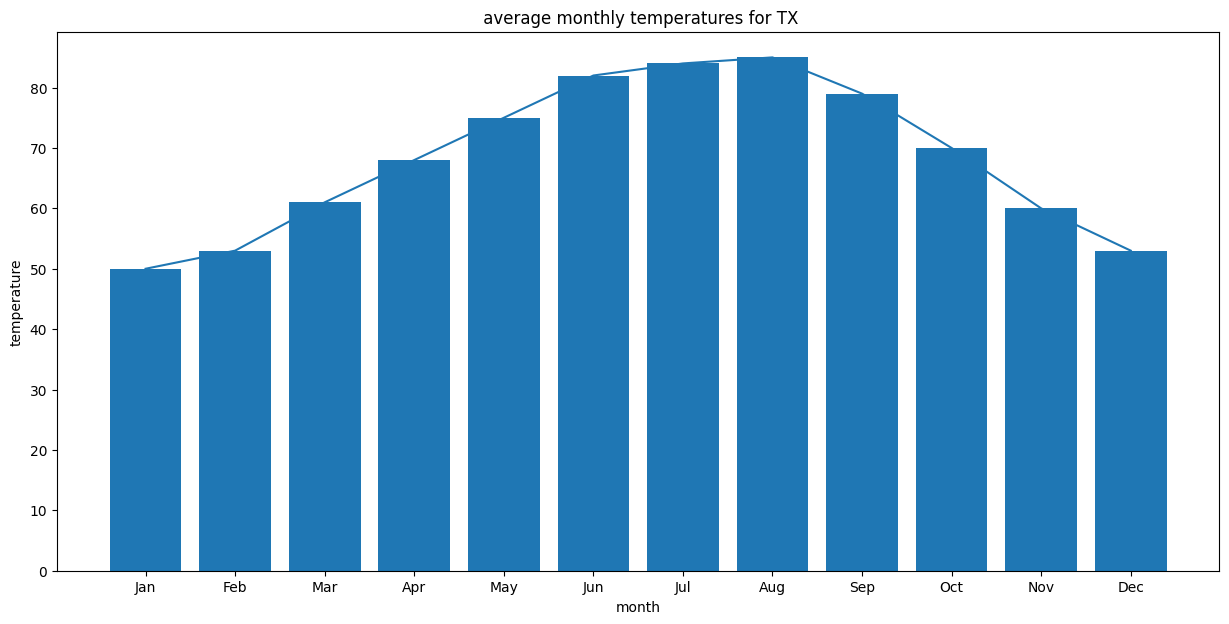

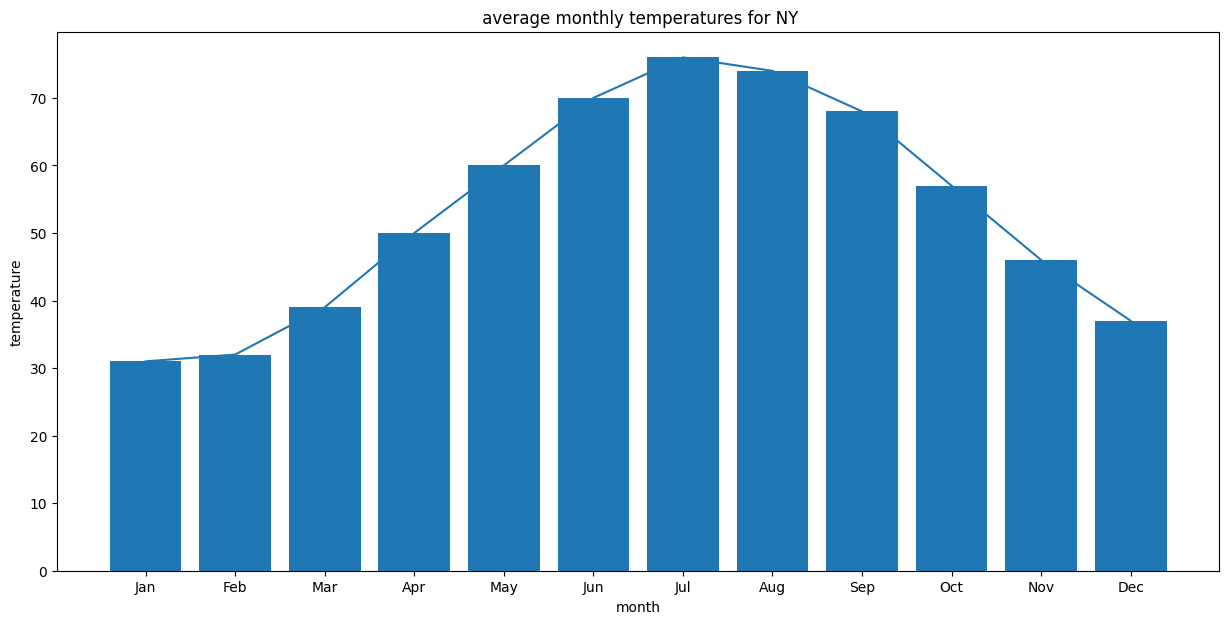

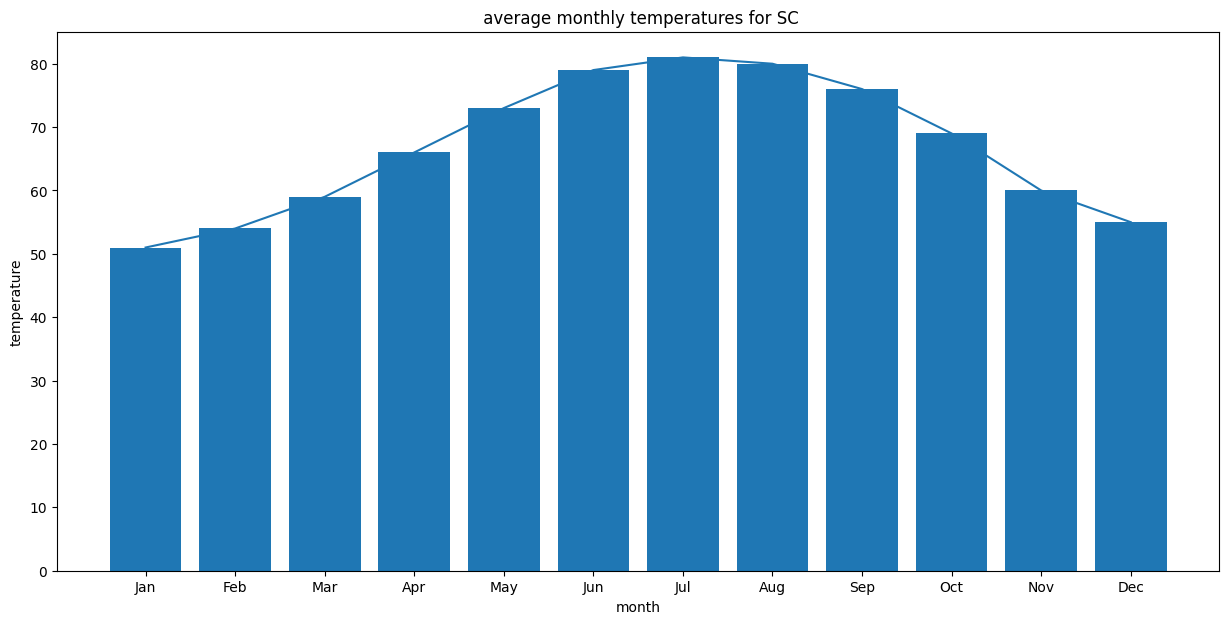

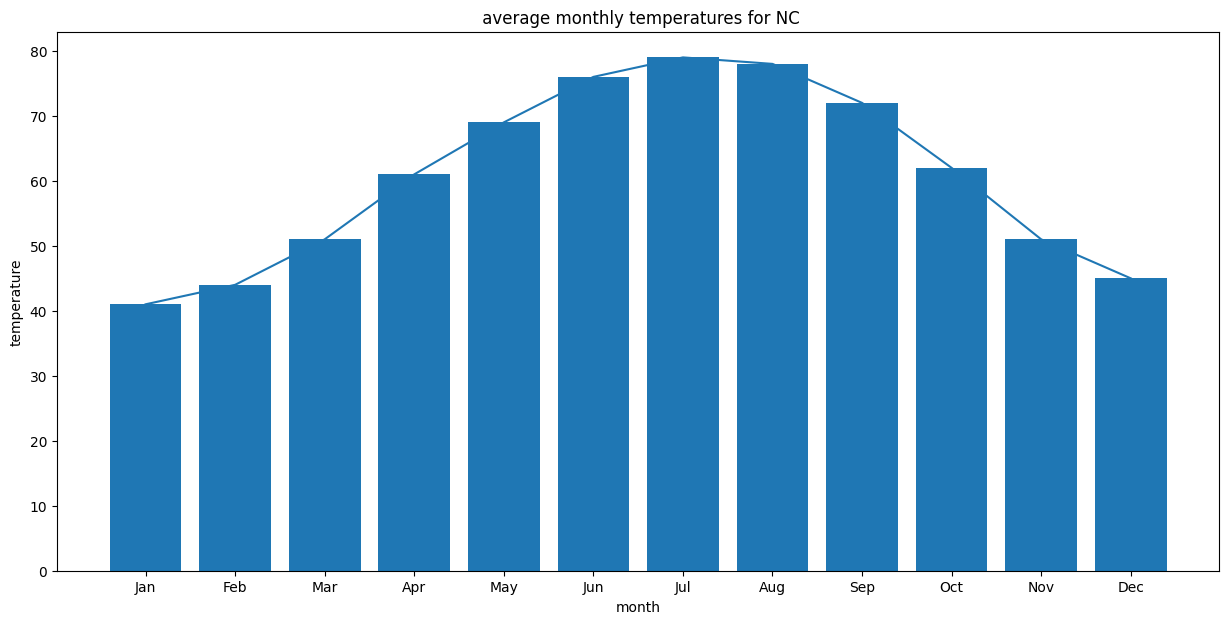

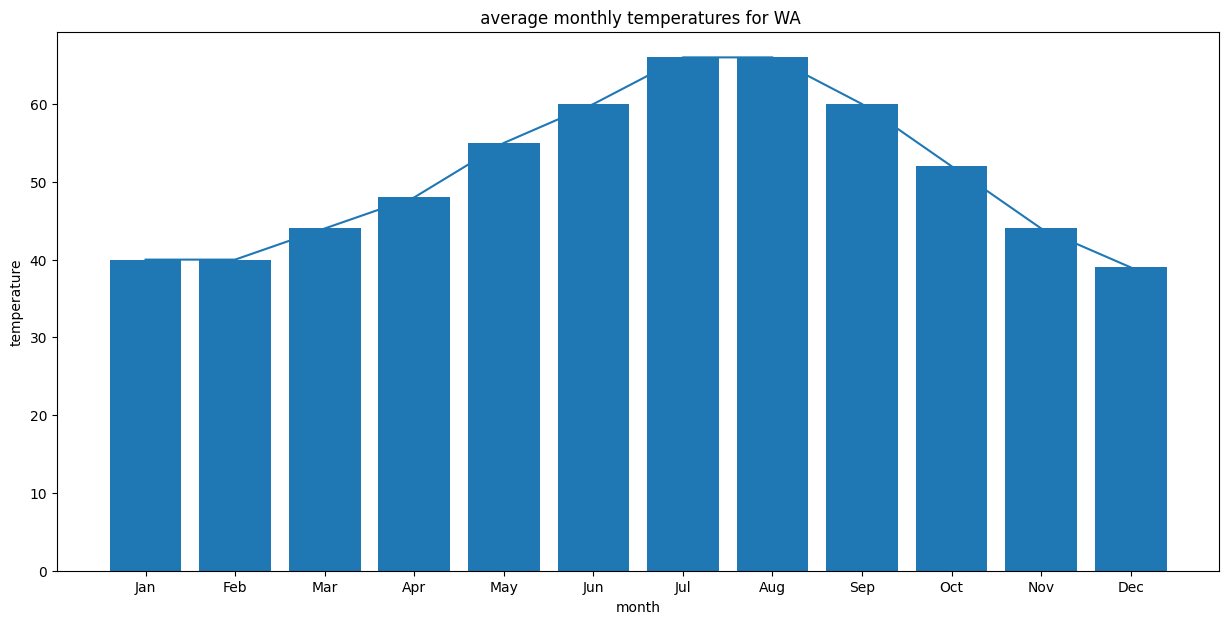

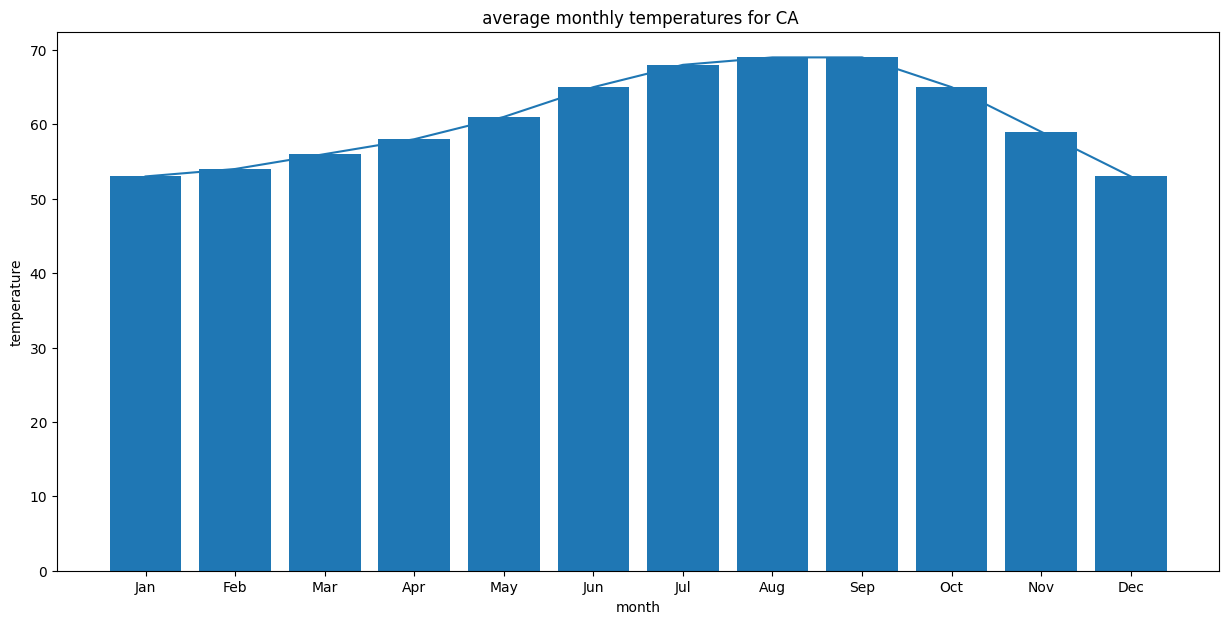

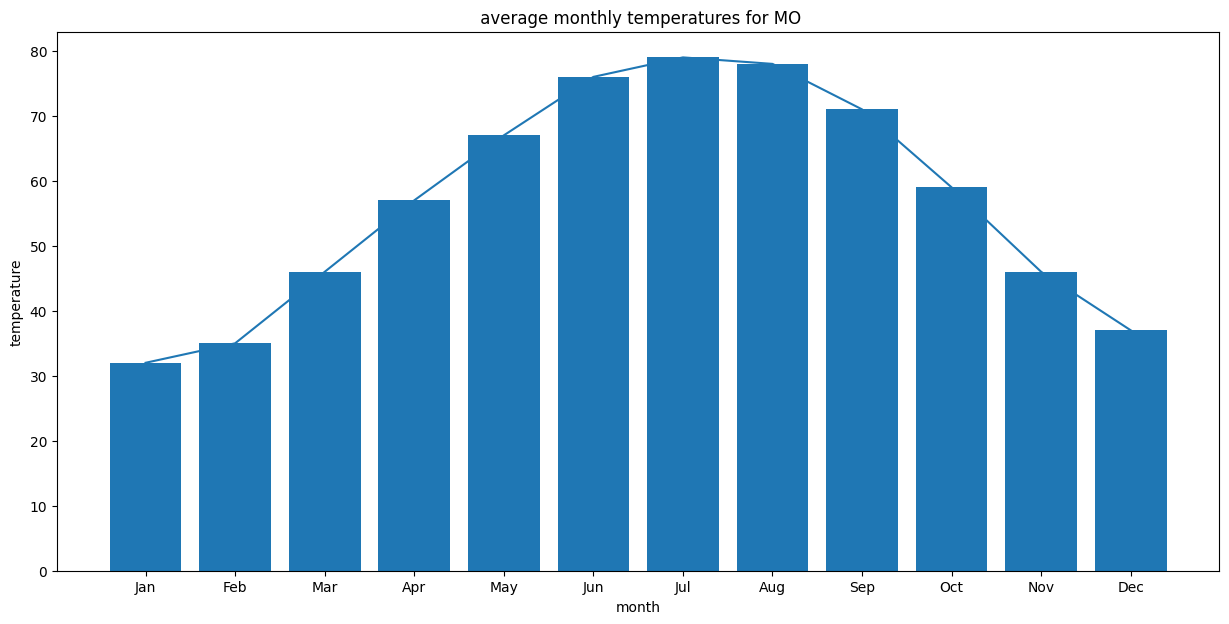

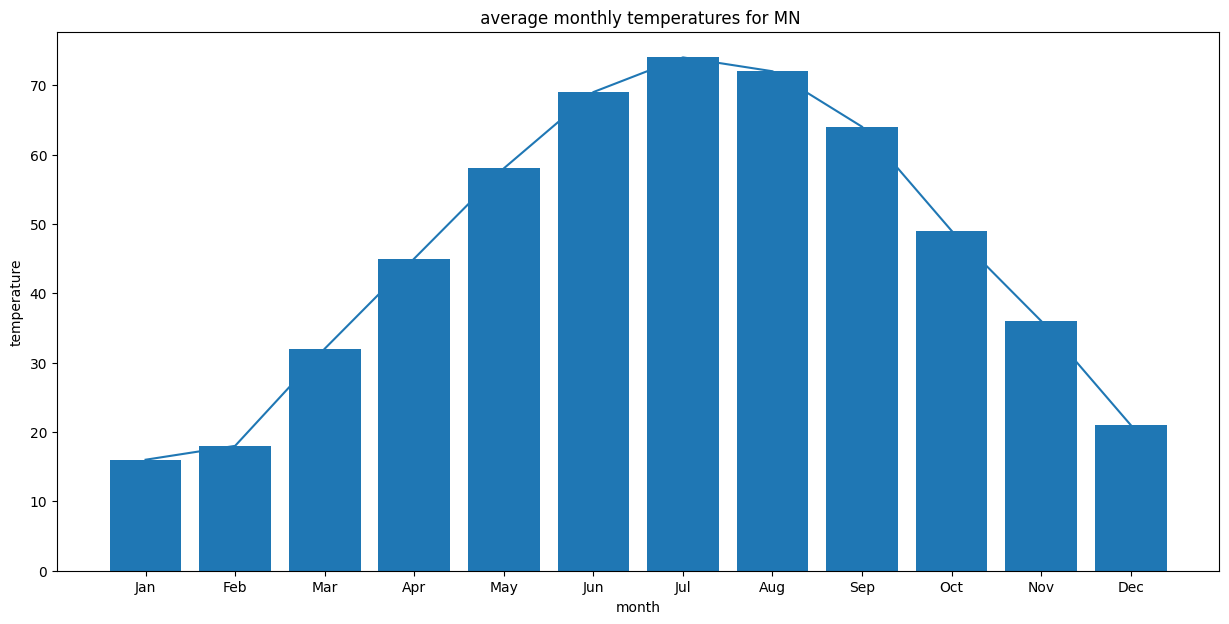

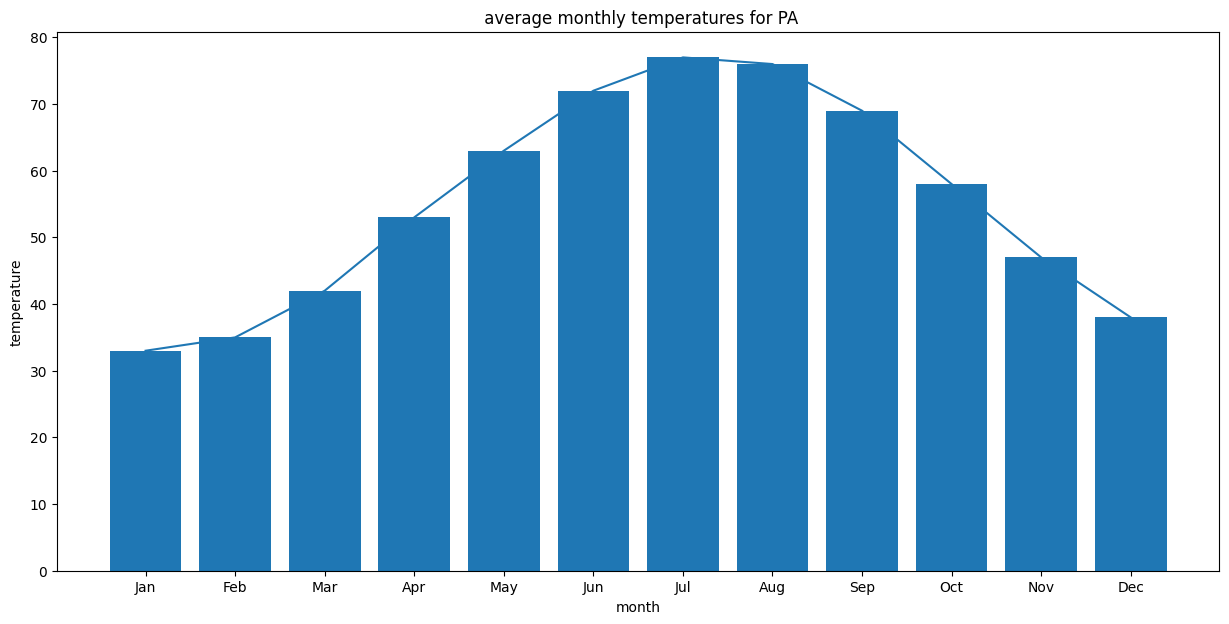

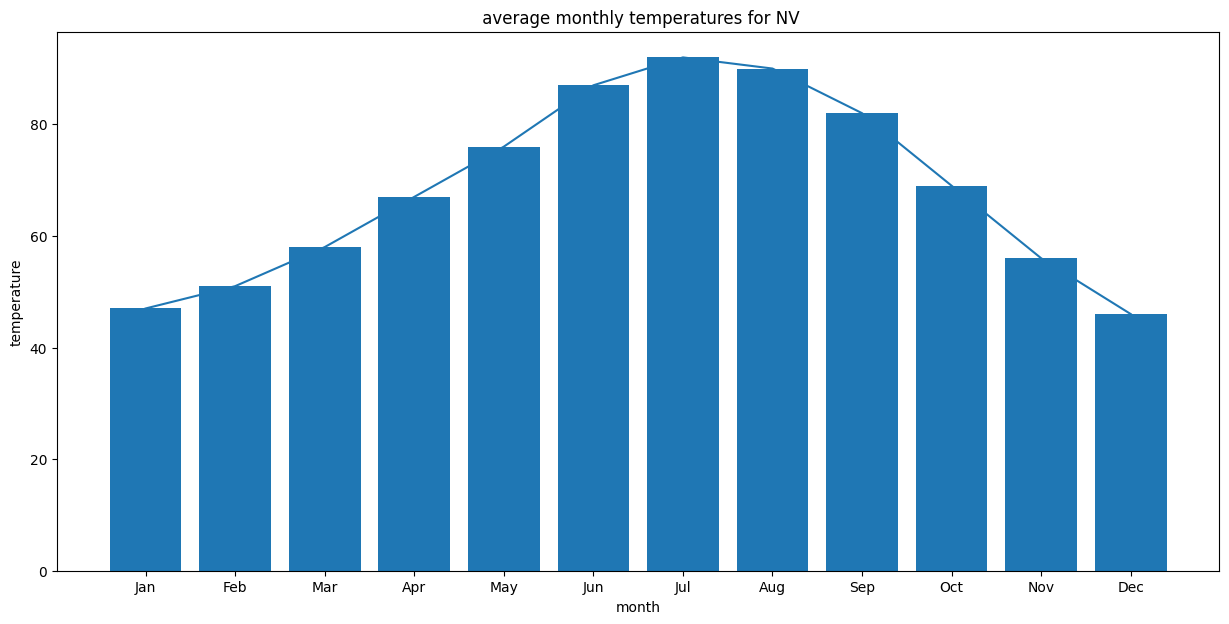

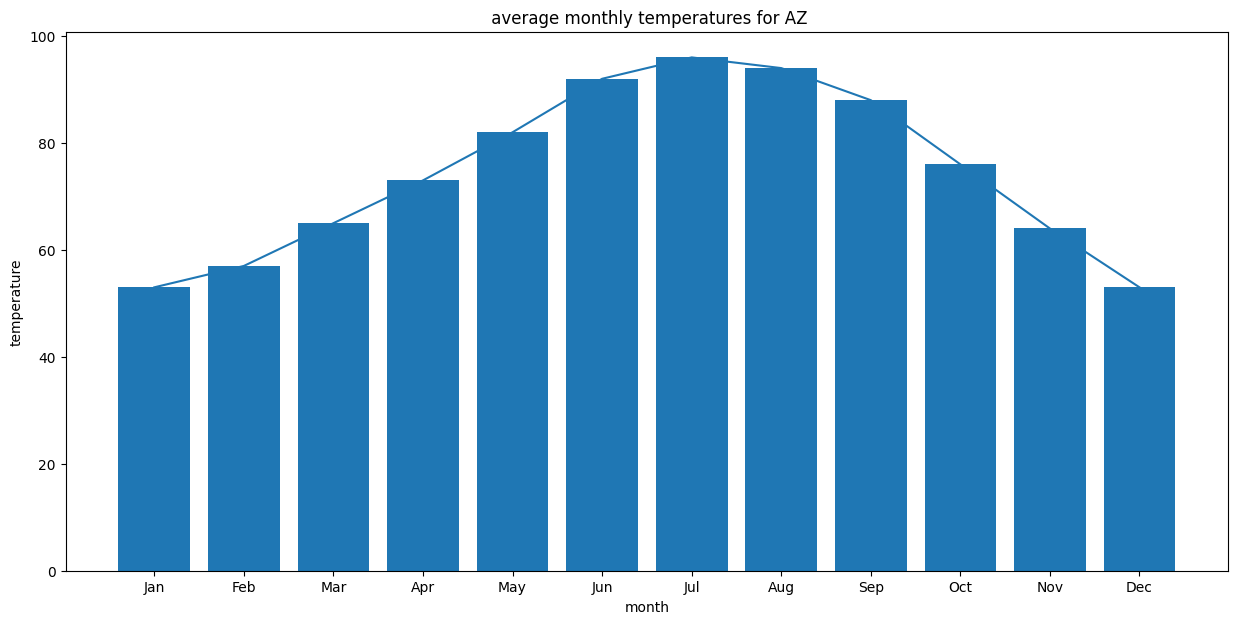

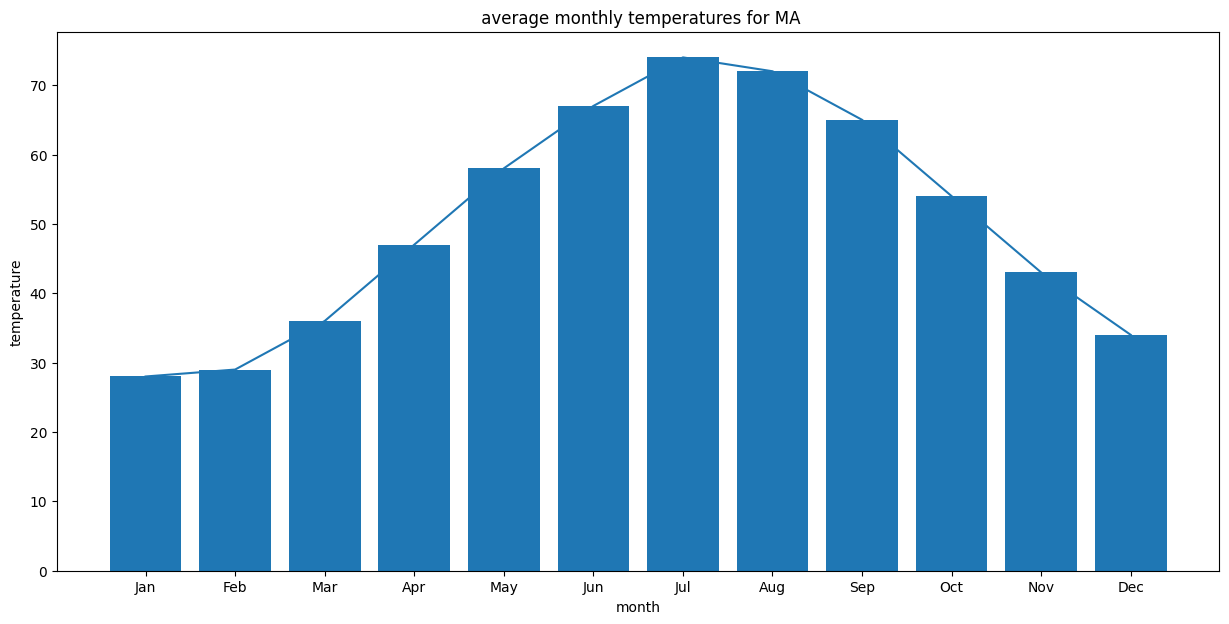

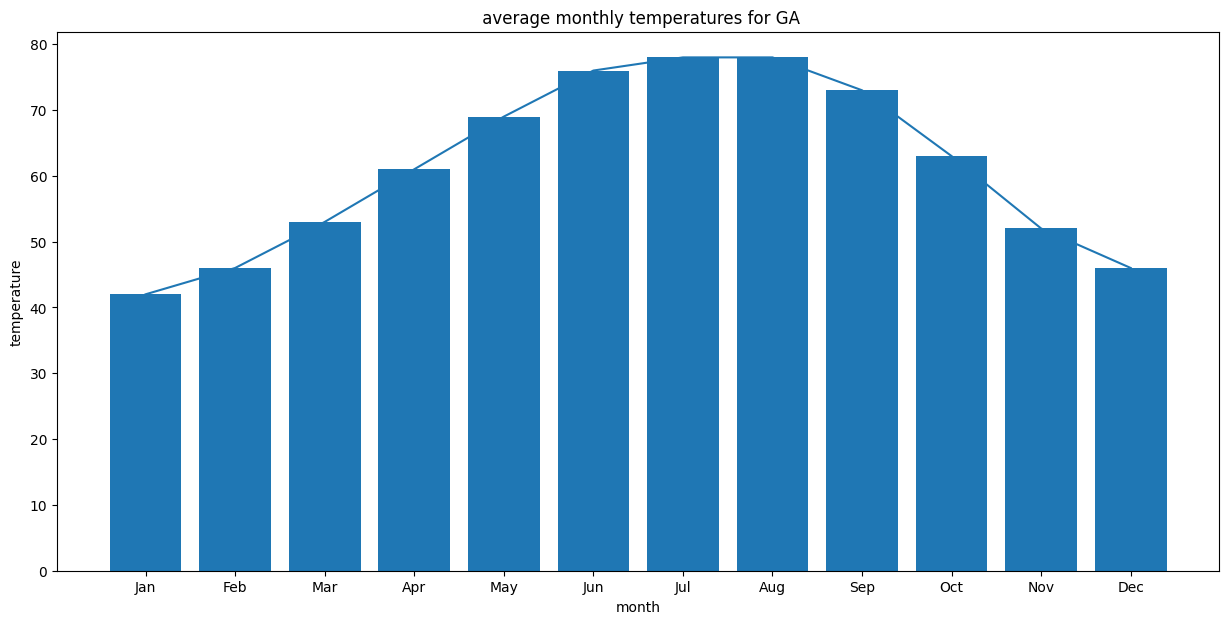

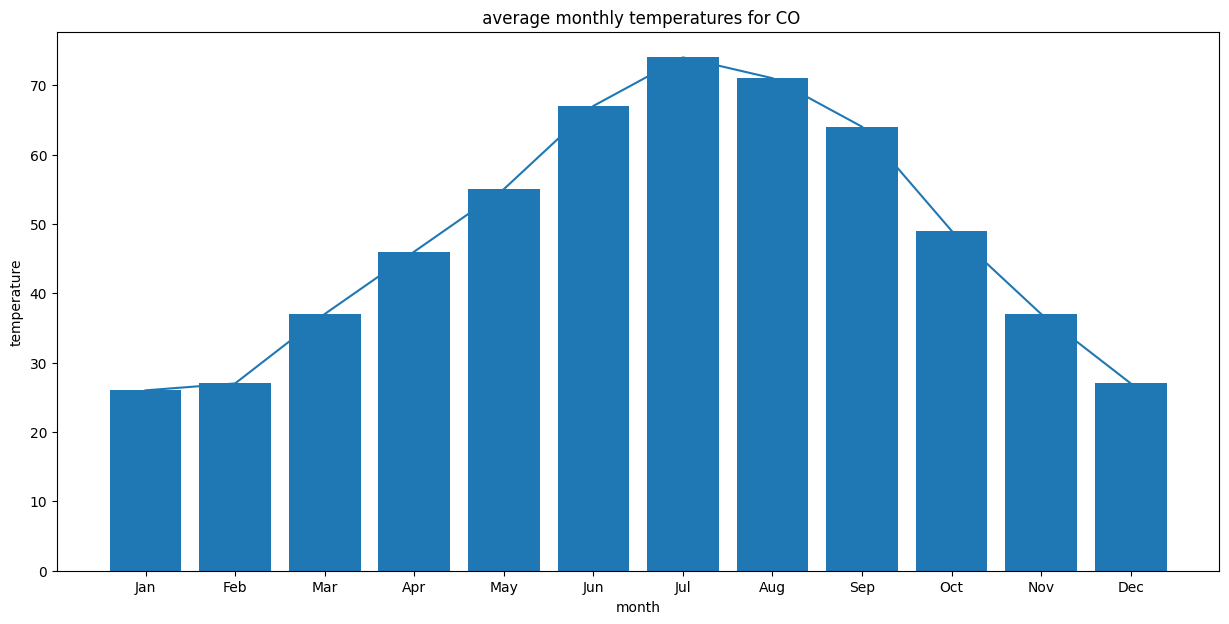

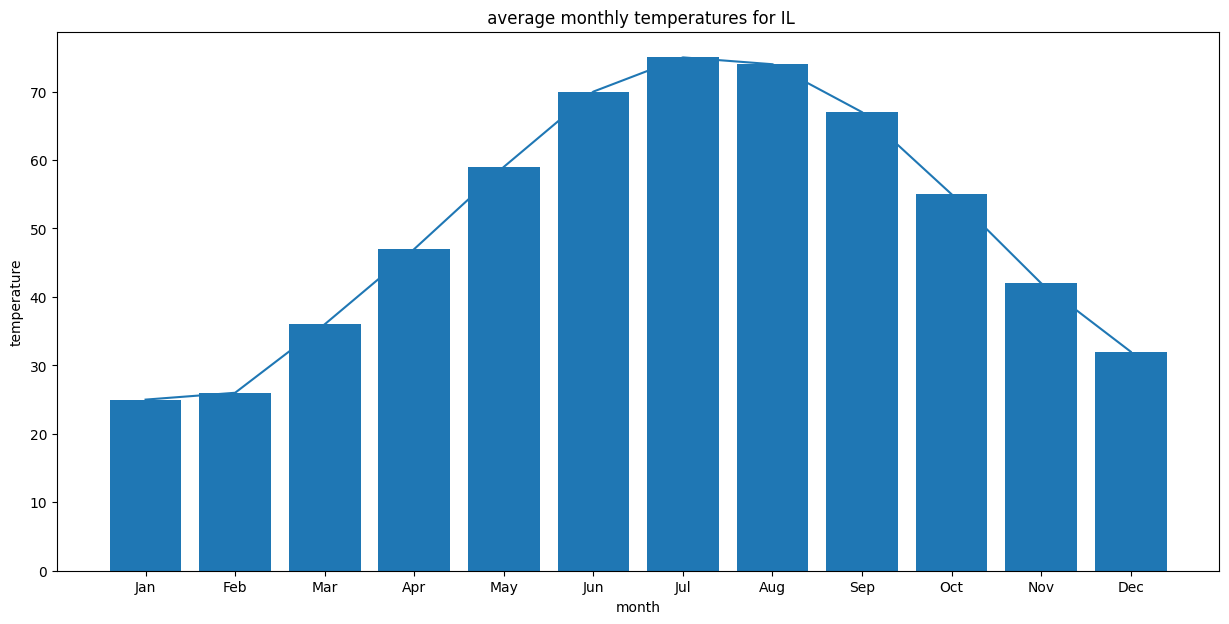

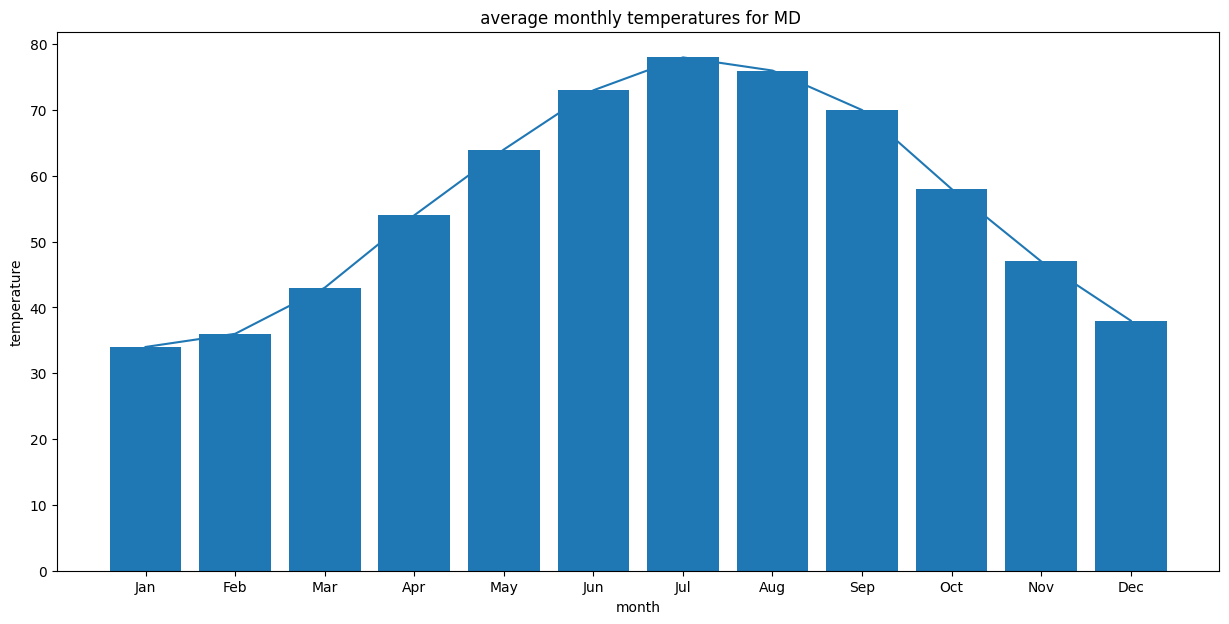

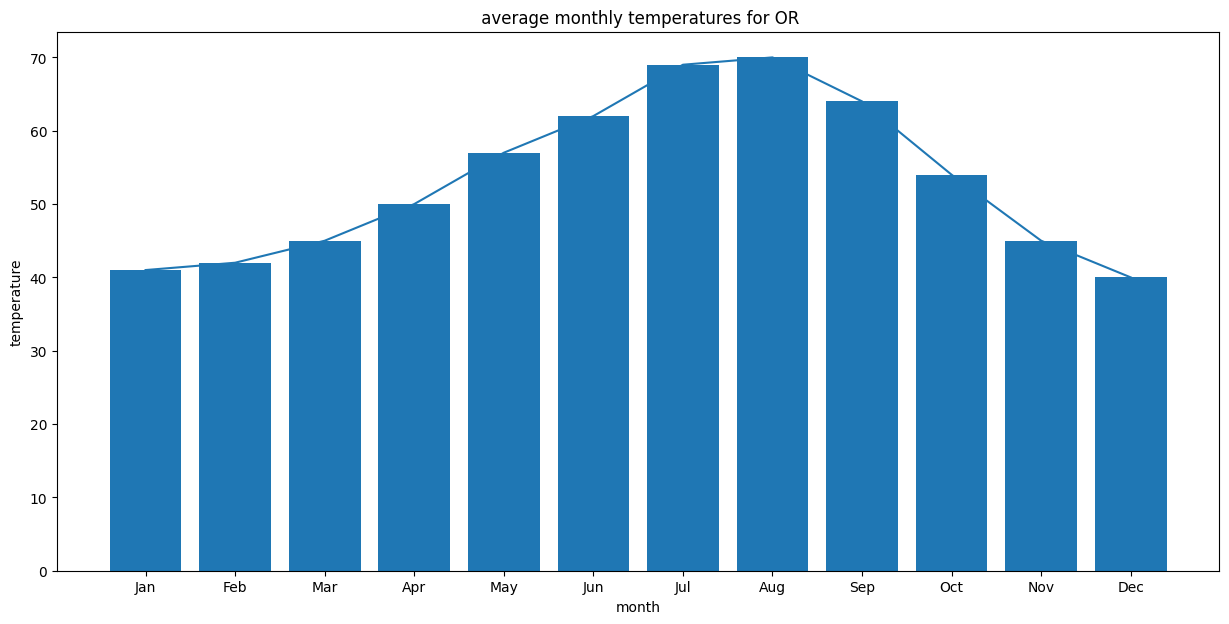

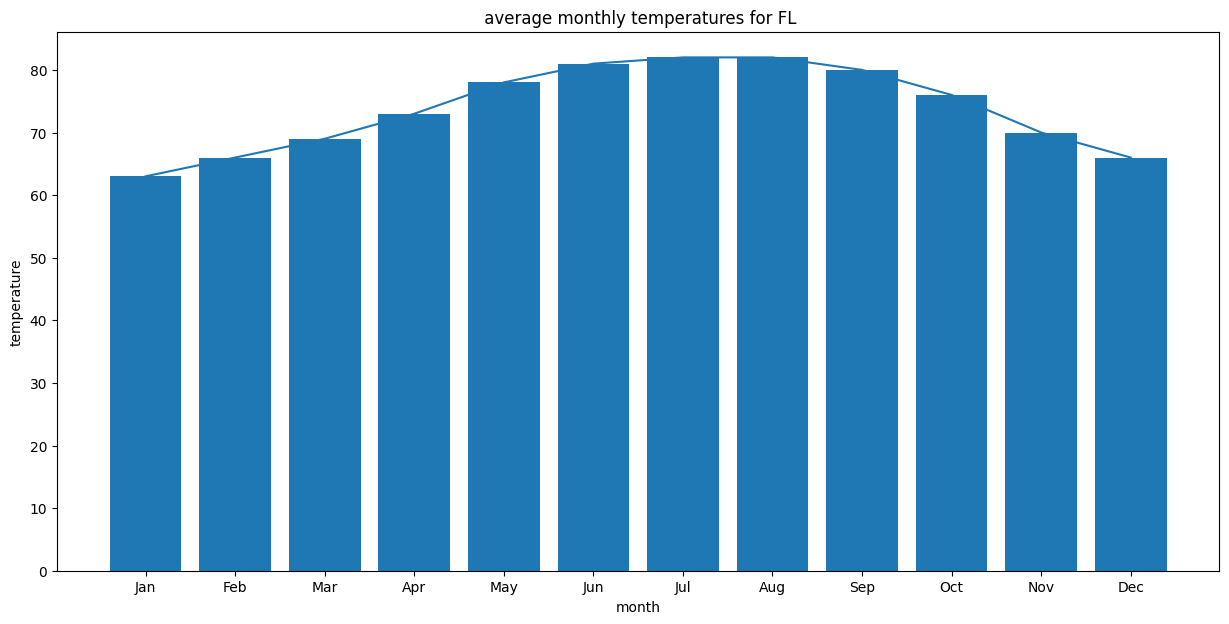

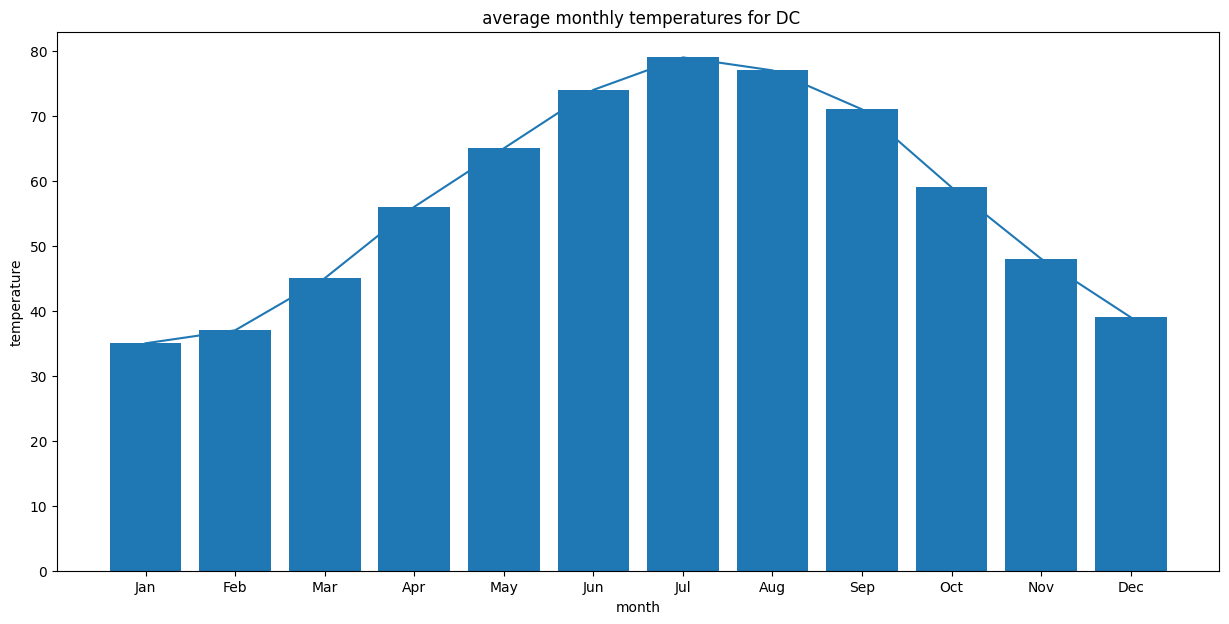

In [85]:
cal = round(states_Monthly.groupby(['stateid', 'month'],as_index=False, sort = False)['temp_mean'].mean())

for i in set(cal.stateid):
    statecal = cal[cal['stateid']== i]
    fig, ax = plt.subplots(figsize=(15,7))
    plt.title(f' average monthly temperatures for {i}')
    ax.set_xlabel('month')
    ax.set_ylabel('temperature')
    x = statecal['month']
    y = statecal['temp_mean']
    tickvalues = range(0,len(x))
  
    plt.xticks(ticks = tickvalues ,labels = x)
    plt.plot(x,y)
   
    plt.bar(x,y)

# Step 3: Merging Dataframes and Using Machine Learning Models

## Merging the data into one data set

In [86]:
client = MongoClient("mongodb://localhost:27017/")  
db = client["ist652"]  
collection = db["eia_data"]

data_cursor = collection.find({})

eia_data_df = pd.DataFrame(list(data_cursor))


if '_id' in eia_data_df.columns:
    eia_data_df.drop(columns=['_id'], inplace=True)


client.close()


print(eia_data_df.head())  

    period stateid stateDescription sectorid      sectorName  customers  \
0  2023-11      CO         Colorado      RES     residential    2469419   
1  2023-11      US       U.S. Total      TRA  transportation         80   
2  2023-11      US       U.S. Total      RES     residential  141052683   
3  2023-11      US       U.S. Total      OTH           other       None   
4  2023-11      US       U.S. Total      IND      industrial    1067082   

   price      revenue         sales      customers-units  \
0  14.61    206.53028    1413.49032  number of customers   
1  14.06     80.54434     572.75798  number of customers   
2  16.19  16616.69643  102609.84787  number of customers   
3   None         None          None  number of customers   
4    7.9   6420.28335   81292.11309  number of customers   

              price-units    revenue-units            sales-units  
0  cents per kilowatthour  million dollars  million kilowatthours  
1  cents per kilowatthour  million dollars  million 

In [87]:
eia_df = pd.DataFrame(eia_data_df)

In [89]:
client = MongoClient("mongodb://localhost:27017/")  
db = client["ist652"]  
collection = db["weather"]

data_cursor = collection.find({})

weather_data_df = pd.DataFrame(list(data_cursor))


if '_id' in weather_data_df.columns:
    weather_data_df.drop(columns=['_id'], inplace=True)


client.close()


print(weather_data_df.head())  

   index       date  max_temp  min_temp  temp_mean  sunshine_duration  \
0      0 2001-01-01      27.0      12.0       19.0            29145.0   
1      1 2001-01-02      23.0       6.0       14.0            29262.0   
2      2 2001-01-03      23.0       4.0       12.0            29280.0   
3      3 2001-01-04      29.0       6.0       14.0            25315.0   
4      4 2001-01-05      31.0       8.0       19.0             5519.0   

   precipitation     location     lon      lat stateid  
0       0.000000  New York,NY -74.006  40.7143      NY  
1       0.000000  New York,NY -74.006  40.7143      NY  
2       0.000000  New York,NY -74.006  40.7143      NY  
3       0.000000  New York,NY -74.006  40.7143      NY  
4       0.141732  New York,NY -74.006  40.7143      NY  


In [90]:
weather_df = pd.DataFrame(weather_data_df)

In [91]:
# Converting the 'period' in the energy data and 'date' in the weather data to datetime format
eia_df['period'] = pd.to_datetime(eia_df['period'], format='%Y-%m')
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Creating a new column for year-month in the weather data to match the energy data's period format
weather_df['year_month'] = weather_df['date'].dt.to_period('M')

# Aggregate weather data on a monthly level for each state
# Using mean and sum for aggregation
df_weather_monthly = weather_df.groupby(['stateid', 'year_month']).agg({
    'max_temp': 'mean',
    'min_temp': 'mean',
    'temp_mean': 'mean',
    'sunshine_duration': 'sum',  
    'precipitation': 'sum'
}).reset_index()

# Converting the 'year_month' back to a datetime format for merging
df_weather_monthly['year_month'] = df_weather_monthly['year_month'].dt.to_timestamp()

# Merging the datasets on 'stateid' and the period/year_month columns
df_merged = pd.merge(eia_df, df_weather_monthly, left_on=['stateid', 'period'], right_on=['stateid', 'year_month'])



customers-units,price-units,revenue-units, and sales-units year_month are best to remove because they are non numeric features and we already have a date column.

In [92]:
df_merged = df_merged.drop(columns=['customers-units','price-units','revenue-units','sales-units','year_month'])

Other variables that would not work well as features:

'state_description' should be removed because it is repetitive to 'state_id'. The same goes to 'sectorName'. 

In regards to price, revenue and sales, the goal is that sales is the independent variable and what we are predicting. Revenue would most likely give our model too much look ahead bias and perhaps mathematically calculate what the sales should be. Given that, the 'revenue' variable will also be removed. 

Then, there is the problem of temperatures. The a pricing model obviosuly cannot make a prediction of the sales by waiting until the end of the day to know what the max and min temp is going to be. It would be too late at that point and the sales can already be concluded. That is why we will only leave the 'mean' price in for our model. 

In [93]:
df_merged = df_merged.drop(columns=['stateDescription','customers','sectorName','revenue','max_temp','min_temp'])

Next, we see that columns have the word "None" instead of '0'. But first, we must ensure that the data types above make sense. Price and sales should be changed to numeric before we can get rid of the none issue. This should be changed for the machine learning model. 

In [94]:
df_merged['price'] = pd.to_numeric(df_merged['price'])

In [95]:
df_merged['sales'] = pd.to_numeric(df_merged['sales'])

Now we convert everything with Nan to zero

In [96]:
df_merged['price'] = df_merged['price'].fillna(0)
df_merged['sales'] = df_merged['sales'].fillna(0)

Now need to drop all rows with "ALL" as sector ID because this is repetitive data.

In [97]:
df_merged = df_merged.loc[df_merged['sectorid'] != 'ALL']

Finally, machine learning models no not like categorical variables. So we will use hot encoding to convert our categorical variables: stateid, sectorid

In [98]:
df_encoded = pd.get_dummies(df_merged, columns=['stateid', 'sectorid'])

In [99]:
df_encoded['period_year'] = df_encoded['period'].dt.year

In [100]:
df_encoded['period_month'] = df_encoded['period'].dt.month

In [101]:
df_encoded = df_encoded.drop(columns=['period'])

In [113]:
df_encoded

,price,sales,temp_mean,sunshine_duration,precipitation,stateid_AZ,stateid_CA,stateid_CO,stateid_DC,stateid_FL,...,stateid_SC,stateid_TX,stateid_WA,sectorid_COM,sectorid_IND,sectorid_OTH,sectorid_RES,sectorid_TRA,period_year,period_month
0,14.61,1413.49032,37.733333,836152.0,0.425197,False,False,True,False,False,...,False,False,False,False,False,False,True,False,2023,11
1,0.00,0.00000,37.733333,836152.0,0.425197,False,False,True,False,False,...,False,False,False,False,False,True,False,False,2023,11
2,8.47,1198.58110,37.733333,836152.0,0.425197,False,False,True,False,False,...,False,False,False,False,True,False,False,False,2023,11
3,11.49,1531.30601,37.733333,836152.0,0.425197,False,False,True,False,False,...,False,False,False,True,False,False,False,False,2023,11
5,9.73,7.15153,37.733333,836152.0,0.425197,False,False,True,False,False,...,False,False,False,False,False,False,False,True,2023,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31428,7.99,3646.72952,28.903226,717398.0,2.984252,False,False,False,False,False,...,False,False,False,True,False,False,False,False,2001,1
31429,5.93,3792.55225,28.903226,717398.0,2.984252,False,False,False,False,False,...,False,False,False,False,True,False,False,False,2001,1
31430,8.54,154.28539,28.903226,717398.0,2.984252,False,False,False,False,False,...,False,False,False,False,False,True,False,False,2001,1
31431,8.74,5112.70176,28.903226,717398.0,2.984252,False,False,False,False,False,...,False,False,False,False,False,False,True,False,2001,1


# Using Regression

In [102]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('sales', axis=1)
y = df_encoded['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [103]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [104]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predicting the sales for the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


MSE: 2153120.113467609, MAE: 1059.0666061691736, RMSE: 1467.3513939979098, R-squared: 0.6801322926033846


In [105]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
print(f"Cross-validated MSE: {-scores.mean()}")


Cross-validated MSE: 2239797.35895204


Summary: The 'mean squared error' (MSE) is really high suggesting that our sales predictions would be way off. The Mean Absolute Error (MAE) tells us that our sales predictions would be off by 1,059 units.

R² of 0.680: An R² of 0.680 means that about 68% of the variability in sales is explained by the model. While not low, this leaves room for improvement, as approximately 32% of the variance in sales is not captured by the model.

The cross validation MSE: further indicates how much our estimate is off by on average.

 # Using Extreme Gradient Boosting

In [106]:
X = df_encoded.drop('sales', axis=1)  # Features: drop the target variable
y = df_encoded['sales']  # Target variable

In [107]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
import xgboost as xgb

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, seed=42)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error and R-squared between the true and predicted values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 366972.1469693783
R-squared: 0.9454825865982628


The results from your XGBoost model indicate a Mean Squared Error (MSE) of approximately 366972 and an R-squared value of about 0.945.

We see a big improvement in our MSE compared to linear regression and a much better r-squared value.

# Random Forest Algorithm

In [110]:
X = df_encoded.drop('sales', axis=1)  # df_encoded is your prepared DataFrame
y = df_encoded['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [111]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [112]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Making predictions
y_pred = rf_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


MSE: 45094.9372182085, MAE: 85.42556396608778, RMSE: 212.35568562722426, R-squared: 0.9933006922869937


Surpisingly, the random forest algorithm performed the best. It has the lowest MSE and the best R-squared. It is suprising because this algorithm tends to underfit.

# Conclusions

From our analysis, it emerged that the Random Forest algorithm demonstrated superior performance compared to both Regression and XGBoost models. It's noteworthy, however, that our data preprocessing and cleaning efforts resulted in a significantly reduced dataset size—from initially hundreds of thousands of entries to approximately 26,000. While complex machine learning algorithms typically benefit from larger datasets to enhance their predictive accuracy and generalizability, our analysis was constrained to this reduced dataset size due to the nature and quality of the available data.

Despite these limitations, the Random Forest model's relative success underscores its robustness and effectiveness even with smaller datasets. However, to further unlock the potential of our predictive modeling efforts, collecting a more extensive dataset in the future will be crucial. A larger dataset will likely improve model performance by providing a more comprehensive representation of the underlying patterns and relationships.

Additionally, we advocate for continued refinement and optimization of the Random Forest model. Fine-tuning the model's hyperparameters, exploring more sophisticated feature engineering techniques, and employing advanced methods for model evaluation could substantially enhance its predictive capabilities. These steps will not only improve the accuracy of our current predictions but also bolster the model's ability to generalize to new, unseen data, thereby making it a more powerful tool for our analytical objectives.